In [ ]:
HF_HOME = ~/.cache/huggingface/

In [2]:
HF_HOME = "~/.cache/huggingface/"

In [1]:

import pandas as pd
from datasets import load_dataset

/Users/bolongtang/Downloads/TorchSpatial/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds_train = load_dataset('sasha/birdsnap', split = "train", streaming = True, cache_dir = HF_HOME)

In [4]:
three_samples = ds_train.take(3)
three_samples_pd = pd.DataFrame(three_samples)


In [5]:
print(three_samples_pd)

                                               image              label
0  <PIL.Image.Image image mode=RGB size=2011x2459...  Wilsons_Phalarope
1  <PIL.Image.Image image mode=RGB size=1970x1313...  Wilsons_Phalarope
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Wilsons_Phalarope


In [6]:
three_samples_pd.head()

,image,label
0,<PIL.Image.Image image mode=RGB size=2011x2459...,Wilsons_Phalarope
1,<PIL.Image.Image image mode=RGB size=1970x1313...,Wilsons_Phalarope
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Wilsons_Phalarope


In [9]:
import matplotlib.pyplot as plt

def show_image(image, label):
    # Convert tensor to numpy for visualization
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.show()

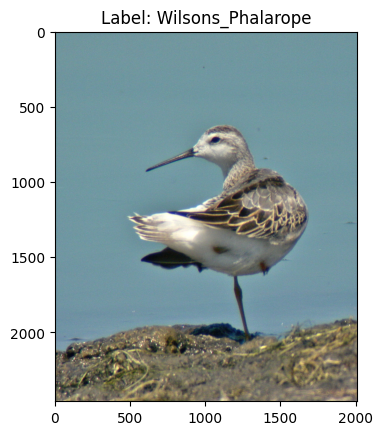

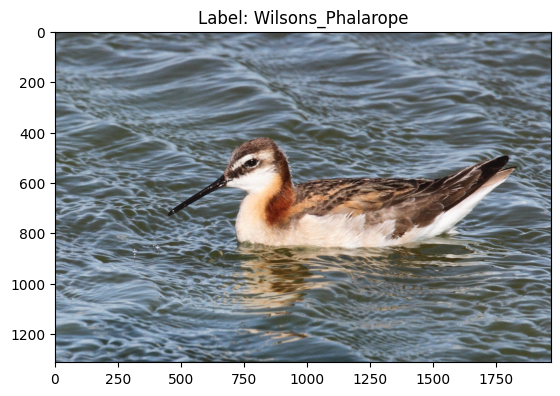

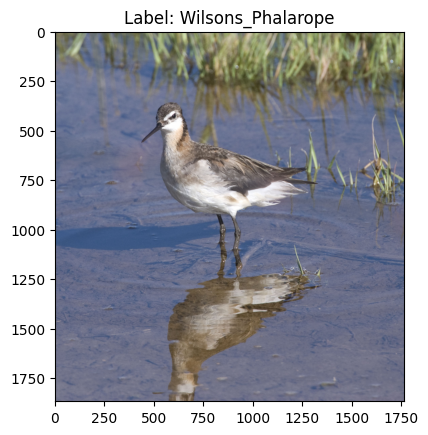

In [17]:

# Visualize the first 3 images in the dataset
for i in range(3):
    image, label = three_samples_pd.iloc[i]
    show_image(image, label)


In [18]:
from PIL import Image

def center_crop_image(image, size=1000):
    width, height = image.size
    left = (width - size) // 2
    top = (height - size) // 2
    right = left + size
    bottom = top + size
    return image.crop((left, top, right, bottom))

three_samples_pd['image'] = three_samples_pd['image'].apply(lambda img: center_crop_image(img, 1000))

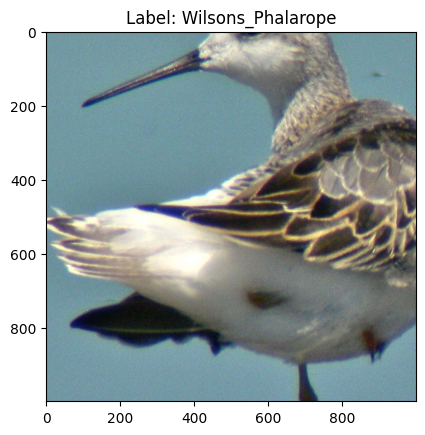

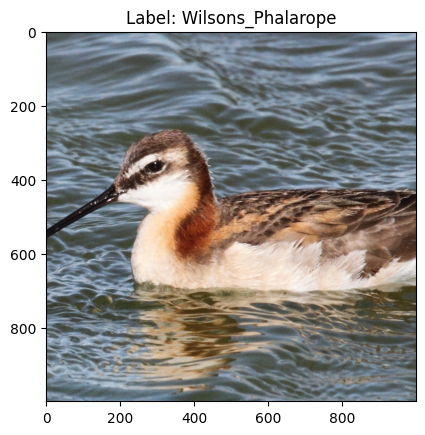

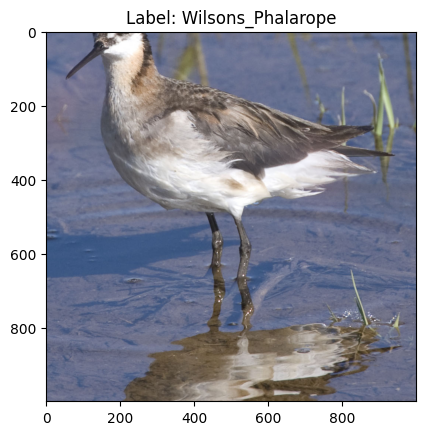

In [19]:
for i in range(3):
    image, label = three_samples_pd.iloc[i]
    show_image(image, label)

In [20]:
import torch
from torchvision import transforms

import torch.nn as nn

# Define image encoder
class ImageEncoder(nn.Module):
    def __init__(self, output_dim=784):
        super(ImageEncoder, self).__init__()
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, output_dim)
        )
    
    def forward(self, x):
        x = self.transforms(x)
        x = x.unsqueeze(0) if x.dim() == 3 else x
        return self.encoder(x)

# Initialize encoder
encoder = ImageEncoder(output_dim=784)

# Encode the three samples
encoded_images = []
for i in range(3):
    img = three_samples_pd.iloc[i]['image']
    with torch.no_grad():
        encoding = encoder(img)
    encoded_images.append(encoding)
    print(f"Sample {i} encoding shape: {encoding.shape}")


Sample 0 encoding shape: torch.Size([1, 784])
Sample 1 encoding shape: torch.Size([1, 784])
Sample 2 encoding shape: torch.Size([1, 784])


In [26]:
print(list(i for i in range(len(encoded_images))))

[0, 1, 2]


In [27]:
class LocationEncoder(nn.Module):
    def __init__(self, output_dim=784):
        super(LocationEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, lat, lon):
        x = torch.tensor([[lat, lon]], dtype=torch.float32)
        return self.encoder(x)

# Initialize location encoder
location_encoder = LocationEncoder(output_dim=784)

In [ ]:
# Example usage with sample coordinates
sample_lat, sample_lon = 40.7128, -74.0060  # New York City
encoded_location = location_encoder(sample_lat, sample_lon)
print(f"Encoded location shape: {encoded_location.shape}")

Encoded location shape: torch.Size([1, 784])


In [30]:
encoded_locations = []
three_locs = [(50, -80), (12, 12), (70, -70)]
for i in range(3):
    loc = three_locs[i]
    with torch.no_grad():
        encoding = location_encoder(lat=loc[0], lon=loc[1])
    encoded_locations.append(encoding)
    print(f"Sample {i} encoding shape: {encoding.shape}")

Sample 0 encoding shape: torch.Size([1, 784])
Sample 1 encoding shape: torch.Size([1, 784])
Sample 2 encoding shape: torch.Size([1, 784])


In [32]:
embedding_interactions = []
for i in range(3):
    interaction = torch.mul(encoded_images[i], encoded_locations[i])
    embedding_interactions.append(interaction)
    print(f"Sample {i} interaction shape: {interaction.shape}")

Sample 0 interaction shape: torch.Size([1, 784])
Sample 1 interaction shape: torch.Size([1, 784])
Sample 2 interaction shape: torch.Size([1, 784])


In [37]:
torch.all(torch.mul(encoded_images[0], encoded_locations[0]) == embedding_interactions[0])

tensor(True)

In [39]:
class MLPDecoder(nn.Module):
    def __init__(self, input_dim=784, output_dim=500):
        super(MLPDecoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    
    def forward(self, x):
        return self.mlp(x)

# Initialize decoder
decoder = MLPDecoder(input_dim=784, output_dim=500)

In [42]:
class_predictions = []
for x in embedding_interactions:
    y = torch.softmax(decoder(x), dim = 1)
    class_predictions.append(y)

In [55]:
class_predictions[0][0][:5]

tensor([0.0020, 0.0022, 0.0020, 0.0020, 0.0020], grad_fn=<SliceBackward0>)

In [65]:
val, ind = torch.max(class_predictions[0], 1)

In [66]:
print(val, ind)

tensor([0.0022], grad_fn=<MaxBackward0>) tensor([111])


In [67]:
val, ind = torch.max(class_predictions[1], 1)
print(val, ind)

tensor([0.0022], grad_fn=<MaxBackward0>) tensor([204])
